In [1]:
# =====================================================================
# BLOCK 1: IMPORTS AND INITIAL SETUP
# =====================================================================
print("🚀 STARTING LANE DETECTION MODEL - FULL DATASET")

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import pickle
from sklearn.model_selection import train_test_split
import psutil
import humanize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("✅ Libraries imported successfully!")

🚀 STARTING LANE DETECTION MODEL - FULL DATASET


2026-02-08 03:09:15.162880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770520155.364565      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770520155.417296      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770520155.868006      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770520155.868041      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770520155.868043      55 computation_placer.cc:177] computation placer alr

✅ Libraries imported successfully!


In [2]:
# =====================================================================
# BLOCK 2: CONFIGURATION CONSTANTS
# =====================================================================
print("\n" + "="*60)
print("⚙️ SETUP AND CONFIGURATION")
print("="*60)

# Constants
IMG_SIZE = (224, 224)  # Standard size for VGG16
IMAGE_FOLDER = "images"  # Update with your image folder
MASK_FOLDER = "masks"    # Update with your mask folder

print(f"📐 Image size: {IMG_SIZE}")
print(f"📁 Image folder: {IMAGE_FOLDER}")
print(f"📁 Mask folder: {MASK_FOLDER}")


⚙️ SETUP AND CONFIGURATION
📐 Image size: (224, 224)
📁 Image folder: images
📁 Mask folder: masks


In [3]:
# =====================================================================
# BLOCK 3: LOAD DATASET FUNCTION (Direct Paths)
# =====================================================================
print("\n" + "="*60)
print("📂 LOADING CULANE DATASET")
print("="*60)

import os
import json
from sklearn.model_selection import train_test_split

# Direct Kaggle paths (verified)
MASK_FOLDER = "/kaggle/input/culane-preprocessed/temp/masks"
IMAGE_FOLDER = "/kaggle/input/culane-preprocessed/temp/frames"

print(f"📁 Using direct Kaggle paths:")
print(f"  ✓ Mask folder:  {MASK_FOLDER}")
print(f"  ✓ Image folder: {IMAGE_FOLDER}")

# Quick verification
print("\n🔍 Verifying paths...")
if not os.path.exists(MASK_FOLDER):
    print(f"❌ ERROR: Mask folder not found: {MASK_FOLDER}")
    raise FileNotFoundError(f"Mask folder not found: {MASK_FOLDER}")

if not os.path.exists(IMAGE_FOLDER):
    print(f"❌ ERROR: Image folder not found: {IMAGE_FOLDER}")
    raise FileNotFoundError(f"Image folder not found: {IMAGE_FOLDER}")

print("✅ Both folders exist!")

# Get file lists
print("\n📥 Getting file lists...")
try:
    mask_files = sorted(os.listdir(MASK_FOLDER))
    image_files = sorted(os.listdir(IMAGE_FOLDER))
    
    print(f"📊 File count:")
    print(f"  ✓ Images: {len(image_files)} files")
    print(f"  ✓ Masks:  {len(mask_files)} files")
    
    # Show first few files
    print(f"\n📋 Sample images (first 5):")
    for i, f in enumerate(image_files[:5]):
        print(f"  {i+1}. {f}")
    
    print(f"\n📋 Sample masks (first 5):")
    for i, f in enumerate(mask_files[:5]):
        print(f"  {i+1}. {f}")
        
except Exception as e:
    print(f"❌ Error reading folders: {e}")
    raise

def match_files_by_name(image_files, mask_files):
    """Match image and mask files by filename (without extension)"""
    print("\n🔗 Matching images with masks...")
    
    # Create dictionaries with base names (without extension)
    image_dict = {}
    for img_file in image_files:
        base = os.path.splitext(img_file)[0]
        image_dict[base] = img_file
    
    mask_dict = {}
    for mask_file in mask_files:
        base = os.path.splitext(mask_file)[0]
        mask_dict[base] = mask_file
    
    # Find common base names
    common_bases = set(image_dict.keys()) & set(mask_dict.keys())
    
    print(f"📊 Found {len(common_bases)} matching pairs")
    
    if len(common_bases) == 0:
        print("⚠️ No exact matches found. Trying case-insensitive matching...")
        
        # Try case-insensitive
        image_lower = {k.lower(): v for k, v in image_dict.items()}
        mask_lower = {k.lower(): v for k, v in mask_dict.items()}
        common_bases = set(image_lower.keys()) & set(mask_lower.keys())
        
        if common_bases:
            print(f"✅ Found {len(common_bases)} matches (case-insensitive)")
            image_dict = image_lower
            mask_dict = mask_lower
        else:
            print("❌ Still no matches found")
            return [], []
    
    # Create matched lists
    matched_images = []
    matched_masks = []
    
    for base in sorted(common_bases):
        matched_images.append(image_dict[base])
        matched_masks.append(mask_dict[base])
    
    print(f"\n📋 Verified matched pairs (first 5):")
    for i in range(min(5, len(matched_images))):
        print(f"  {i+1}. {matched_images[i]:25} ↔ {matched_masks[i]:25}")
    
    return matched_images, matched_masks

# Match files
matched_images, matched_masks = match_files_by_name(image_files, mask_files)

if len(matched_images) == 0:
    print("\n❌ CRITICAL: No matching files found!")
    print("\n💡 Possible solutions:")
    print("  1. Check if filenames match (e.g., '001.jpg' and '001.png')")
    print("  2. Check file extensions")
    print("  3. Manual matching required")
    
    # Show what we have
    print("\n📁 Available files comparison:")
    print(f"{'Images (first 10)':30} {'Masks (first 10)':30}")
    print("-" * 60)
    for i in range(max(10, min(len(image_files), len(mask_files)))):
        img = image_files[i] if i < len(image_files) else ""
        mask = mask_files[i] if i < len(mask_files) else ""
        print(f"{img:30} {mask:30}")
    
    raise ValueError("No matching image-mask pairs found!")

# Split dataset
print(f"\n📊 Splitting {len(matched_images)} matched pairs...")
train_images, temp_images, train_masks, temp_masks = train_test_split(
    matched_images, matched_masks, 
    test_size=0.3, 
    random_state=42,
    shuffle=True
)

val_images, test_images, val_masks, test_masks = train_test_split(
    temp_images, temp_masks, 
    test_size=0.5, 
    random_state=42,
    shuffle=True
)

print(f"\n✅ Dataset split complete:")
print(f"  Training:   {len(train_images)} pairs ({len(train_images)/len(matched_images)*100:.1f}%)")
print(f"  Validation: {len(val_images)} pairs ({len(val_images)/len(matched_images)*100:.1f}%)")
print(f"  Test:       {len(test_images)} pairs ({len(test_images)/len(matched_images)*100:.1f}%)")

# Save split info
split_info = {
    "total_pairs": len(matched_images),
    "train_count": len(train_images),
    "val_count": len(val_images),
    "test_count": len(test_images),
    "train_percentage": len(train_images)/len(matched_images)*100,
    "val_percentage": len(val_images)/len(matched_images)*100,
    "test_percentage": len(test_images)/len(matched_images)*100,
    "image_folder": IMAGE_FOLDER,
    "mask_folder": MASK_FOLDER,
    "sample_train": list(zip(train_images[:3], train_masks[:3])),
    "sample_val": list(zip(val_images[:3], val_masks[:3])),
    "sample_test": list(zip(test_images[:3], test_masks[:3]))
}

with open('dataset_split_info.json', 'w') as f:
    json.dump(split_info, f, indent=2)

print(f"\n💾 Split information saved to 'dataset_split_info.json'")

# Verify file accessibility
print("\n✅ Verifying file accessibility...")
test_pairs = [
    (train_images[0], train_masks[0], "Training"),
    (val_images[0], val_masks[0], "Validation"),
    (test_images[0], test_masks[0], "Test")
]

all_good = True
for img_file, mask_file, split_name in test_pairs:
    img_path = os.path.join(IMAGE_FOLDER, img_file)
    mask_path = os.path.join(MASK_FOLDER, mask_file)
    
    img_exists = os.path.exists(img_path)
    mask_exists = os.path.exists(mask_path)
    
    if img_exists and mask_exists:
        print(f"  ✓ {split_name}: {img_file} ↔ {mask_file}")
    else:
        print(f"  ✗ {split_name}: Missing {'image' if not img_exists else 'mask'}")
        all_good = False

if not all_good:
    print("⚠️ Some files not accessible. Check permissions/paths.")
else:
    print("✅ All test files accessible!")

# Convert to lists (if they're not already)
train_images = list(train_images)
train_masks = list(train_masks)
val_images = list(val_images)
val_masks = list(val_masks)
test_images = list(test_images)
test_masks = list(test_masks)

print("\n" + "="*60)
print("✅ DATASET LOADED SUCCESSFULLY!")
print("="*60)
print(f"\n📊 FINAL DATASET READY:")
print(f"  Total pairs:      {len(matched_images)}")
print(f"  Training set:     {len(train_images)} pairs")
print(f"  Validation set:   {len(val_images)} pairs")
print(f"  Test set:         {len(test_images)} pairs")
print(f"  Image dimensions: Will be resized to 224x224")
print(f"  Next step:        Creating data pipeline")

# Variables available for next blocks:
# train_images, train_masks, val_images, val_masks, test_images, test_masks
# IMAGE_FOLDER, MASK_FOLDER


📂 LOADING CULANE DATASET
📁 Using direct Kaggle paths:
  ✓ Mask folder:  /kaggle/input/culane-preprocessed/temp/masks
  ✓ Image folder: /kaggle/input/culane-preprocessed/temp/frames

🔍 Verifying paths...
✅ Both folders exist!

📥 Getting file lists...
📊 File count:
  ✓ Images: 120000 files
  ✓ Masks:  120000 files

📋 Sample images (first 5):
  1. 00007f3230d35a893230c1b3ef8c52fd.jpg
  2. 00009c0cc6d565120a31c4a5845d3f64.jpg
  3. 0001c9731b280992fbefd879e0eeae34.jpg
  4. 00022953ff37d3174cff99833df8799e.jpg
  5. 00024e3ed602bfce786d5aff3f2f2c63.jpg

📋 Sample masks (first 5):
  1. 00007f3230d35a893230c1b3ef8c52fd.png
  2. 00009c0cc6d565120a31c4a5845d3f64.png
  3. 0001c9731b280992fbefd879e0eeae34.png
  4. 00022953ff37d3174cff99833df8799e.png
  5. 00024e3ed602bfce786d5aff3f2f2c63.png

🔗 Matching images with masks...
📊 Found 120000 matching pairs

📋 Verified matched pairs (first 5):
  1. 00007f3230d35a893230c1b3ef8c52fd.jpg ↔ 00007f3230d35a893230c1b3ef8c52fd.png
  2. 00009c0cc6d565120a31c4a5

In [4]:
# =====================================================================
# BLOCK 4: DATA PIPELINE SETUP
# =====================================================================
print("\n" + "="*60)
print("🚀 CREATING DATA PIPELINE")
print("="*60)

# Settings for full dataset
BATCH_SIZE = 32  # Increased batch size for better GPU utilization
BUFFER_SIZE = 1000
PREFETCH_BUFFER = tf.data.AUTOTUNE

print(f"📦 Batch size: {BATCH_SIZE}")
print(f"🔀 Shuffle buffer: {BUFFER_SIZE}")


🚀 CREATING DATA PIPELINE
📦 Batch size: 32
🔀 Shuffle buffer: 1000


In [5]:
# =====================================================================
# BLOCK 5: DATA LOADING FUNCTIONS
# =====================================================================

@tf.function
def load_image_mask(img_path, mask_path):
    """Load and preprocess image-mask pair"""
    # Image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    # Mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE, method='nearest')
    mask = tf.cast(mask > 127, tf.float32)

    return img, mask

def create_dataset(image_list, mask_list, shuffle=True, is_training=True):
    """Create TensorFlow dataset"""
    # Create full paths
    img_paths = tf.constant([os.path.join(IMAGE_FOLDER, f) for f in image_list])
    mask_paths = tf.constant([os.path.join(MASK_FOLDER, f) for f in mask_list])
    
    # Create dataset
    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    
    # Parallelize loading
    ds = ds.map(
        load_image_mask,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Shuffle only for training
    if shuffle and is_training:
        ds = ds.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True)
    
    # Batch and prefetch
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=PREFETCH_BUFFER)
    
    return ds

In [6]:
# =====================================================================
# BLOCK 6: CREATE DATASETS
# =====================================================================

print("🔄 Creating training dataset...")
train_dataset = create_dataset(train_images, train_masks, shuffle=True, is_training=True)

print("🔄 Creating validation dataset...")
val_dataset = create_dataset(val_images, val_masks, shuffle=False, is_training=False)

print("🔄 Creating test dataset...")
test_dataset = create_dataset(test_images, test_masks, shuffle=False, is_training=False)

# Test the pipeline
print("\n🧪 Testing pipeline...")
for images, masks in train_dataset.take(1):
    print(f"✅ Pipeline test successful!")
    print(f"   Batch shape - Images: {images.shape}, Masks: {masks.shape}")
    print(f"   Image range: [{tf.reduce_min(images):.3f}, {tf.reduce_max(images):.3f}]")
    print(f"   Mask range:  [{tf.reduce_min(masks):.3f}, {tf.reduce_max(masks):.3f}]")
    print(f"   Unique mask values: {tf.unique(tf.reshape(masks, [-1]))[0].numpy()}")

# Calculate steps per epoch
train_steps = max(1, len(train_images) // BATCH_SIZE)
val_steps = max(1, len(val_images) // BATCH_SIZE)
test_steps = max(1, len(test_images) // BATCH_SIZE)

print(f"\n📊 Dataset Statistics:")
print(f"  Training steps per epoch: {train_steps}")
print(f"  Validation steps: {val_steps}")
print(f"  Test steps: {test_steps}")

print("\n🎯 Data pipeline created successfully!")

🔄 Creating training dataset...


I0000 00:00:1770520173.725686      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


🔄 Creating validation dataset...
🔄 Creating test dataset...

🧪 Testing pipeline...
✅ Pipeline test successful!
   Batch shape - Images: (32, 224, 224, 3), Masks: (32, 224, 224, 1)
   Image range: [0.000, 1.000]
   Mask range:  [0.000, 1.000]
   Unique mask values: [0. 1.]

📊 Dataset Statistics:
  Training steps per epoch: 2625
  Validation steps: 562
  Test steps: 562

🎯 Data pipeline created successfully!


In [7]:
# =====================================================================
# BLOCK 7: BUILD VGG16 U-NET MODEL
# =====================================================================
print("\n" + "="*60)
print("🏗️ BUILDING VGG16 U-NET MODEL")
print("="*60)

# Clear any previous models
tf.keras.backend.clear_session()

def VGG16_UNet(input_shape=(224, 224, 3)):
    """Create VGG16-based U-Net model"""
    # Load VGG16 as base
    base = tf.keras.applications.VGG16(
        weights="imagenet", 
        include_top=False, 
        input_shape=input_shape
    )
    
    # Freeze early layers (optional)
    for layer in base.layers:
        layer.trainable = True  # Set to False if you want to freeze

    # Skip connections from VGG16
    s1 = base.get_layer("block1_conv2").output  # 224x224x64
    s2 = base.get_layer("block2_conv2").output  # 112x112x128
    s3 = base.get_layer("block3_conv3").output  # 56x56x256
    s4 = base.get_layer("block4_conv3").output  # 28x28x512
    bridge = base.get_layer("block5_conv3").output  # 14x14x512

    # Decoder with skip connections
    # Upsample bridge and concatenate with s4
    d1 = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=2, padding='same')(bridge)
    d1 = tf.keras.layers.Concatenate()([d1, s4])
    d1 = tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu")(d1)
    d1 = tf.keras.layers.BatchNormalization()(d1)
    d1 = tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu")(d1)
    d1 = tf.keras.layers.BatchNormalization()(d1)

    # Upsample d1 and concatenate with s3
    d2 = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same')(d1)
    d2 = tf.keras.layers.Concatenate()([d2, s3])
    d2 = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu")(d2)
    d2 = tf.keras.layers.BatchNormalization()(d2)
    d2 = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu")(d2)
    d2 = tf.keras.layers.BatchNormalization()(d2)

    # Upsample d2 and concatenate with s2
    d3 = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same')(d2)
    d3 = tf.keras.layers.Concatenate()([d3, s2])
    d3 = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu")(d3)
    d3 = tf.keras.layers.BatchNormalization()(d3)
    d3 = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu")(d3)
    d3 = tf.keras.layers.BatchNormalization()(d3)

    # Upsample d3 and concatenate with s1
    d4 = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(d3)
    d4 = tf.keras.layers.Concatenate()([d4, s1])
    d4 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(d4)
    d4 = tf.keras.layers.BatchNormalization()(d4)
    d4 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(d4)
    d4 = tf.keras.layers.BatchNormalization()(d4)

    # Final upsampling to original size
    d5 = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same')(d4)
    d5 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(d5)
    d5 = tf.keras.layers.BatchNormalization()(d5)
    d5 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(d5)
    d5 = tf.keras.layers.BatchNormalization()(d5)

    # Output layer
    outputs = tf.keras.layers.Conv2D(1, 1, activation="sigmoid")(d5)

    return tf.keras.Model(inputs=base.input, outputs=outputs)

# Create the model
model = VGG16_UNet(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Display model info
print(f"\n📊 MODEL SUMMARY:")
print(f"Input shape:  {model.input_shape}")
print(f"Output shape: {model.output_shape}")
print(f"Parameters:   {model.count_params():,}")
print(f"Model memory: {(model.count_params() * 4) / (1024**2):.2f} MB")

model.summary()
print("✅ Model built successfully!")


🏗️ BUILDING VGG16 U-NET MODEL
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

📊 MODEL SUMMARY:
Input shape:  (None, 224, 224, 3)
Output shape: (None, 448, 448, 1)
Parameters:   28,070,401
Model memory: 107.08 MB


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 28,070,401 (107.08 MB)

 Trainable params: 28,066,433 (107.06 MB)

 Non-trainable params: 3,968 (15.50 KB)

✅ Model built successfully!


In [8]:
# =====================================================================
# BLOCK 8: LOSS FUNCTIONS AND METRICS
# =====================================================================
print("\n" + "="*60)
print("📊 DEFINING LOSS FUNCTIONS AND METRICS")
print("="*60)

def dice_coef(y_true, y_pred):
    """Dice coefficient metric"""
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) + 1)

def dice_loss(y_true, y_pred):
    """Dice loss"""
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    """Combined Binary Cross-Entropy + Dice loss"""
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

def iou_metric(y_true, y_pred):
    """IoU (Jaccard) metric"""
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return (intersection + 1) / (union + 1)

print("✅ Loss functions defined:")
print("  - Dice Coefficient")
print("  - Dice Loss")
print("  - BCE + Dice Loss")
print("  - IoU Metric")


📊 DEFINING LOSS FUNCTIONS AND METRICS
✅ Loss functions defined:
  - Dice Coefficient
  - Dice Loss
  - BCE + Dice Loss
  - IoU Metric


In [9]:
# =====================================================================
# BLOCK 9: COMPILE MODEL
# =====================================================================
print("\n" + "="*60)
print("🚀 STARTING MODEL TRAINING")
print("="*60)

# Compile model with metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=[dice_coef, iou_metric, 'binary_accuracy']
)
print("✅ Model compiled with Adam optimizer (lr=1e-4)")


🚀 STARTING MODEL TRAINING
✅ Model compiled with Adam optimizer (lr=1e-4)


In [10]:
# =====================================================================
# BLOCK 10: TRAINING CALLBACKS
# =====================================================================

# Setup comprehensive training callbacks
callbacks = [
    # Early stopping
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    # Reduce learning rate when stuck
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    # Save best model
    tf.keras.callbacks.ModelCheckpoint(
        'best_lane_model_full.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    # Log training history
    tf.keras.callbacks.CSVLogger('training_log_full.csv'),
    # TensorBoard logging
    tf.keras.callbacks.TensorBoard(
        log_dir='./logs',
        histogram_freq=0,
        write_graph=True,
        write_images=False
    )
]

print(f"\n📊 TRAINING CONFIGURATION:")
print(f"  Training images:   {len(train_images):,}")
print(f"  Validation images: {len(val_images):,}")
print(f"  Test images:       {len(test_images):,}")
print(f"  Batch size:        {BATCH_SIZE}")
print(f"  Training steps:    {train_steps}")
print(f"  Validation steps:  {val_steps}")

# Memory check
print(f"\n🧠 Memory before training: {humanize.naturalsize(psutil.Process(os.getpid()).memory_info().rss)}")


📊 TRAINING CONFIGURATION:
  Training images:   84,000
  Validation images: 18,000
  Test images:       18,000
  Batch size:        32
  Training steps:    2625
  Validation steps:  562

🧠 Memory before training: 2.2 GB



PHASE 1: INITIAL TRAINING

🔍 Verifying shapes before training...
  Input images shape:  (32, 224, 224, 3)
  Target masks shape:  (32, 224, 224, 1)


I0000 00:00:1770520186.177057     121 service.cc:152] XLA service 0x7b34a8007350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770520186.177093     121 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1770520186.471181     121 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-08 03:09:48.569413: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-08 03:09:48.799852: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1770520189.854399     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proc

  Model output shape:  (1, 448, 448, 1)
  ⚠️ SHAPE MISMATCH!
    Masks: (224, 224)
    Predictions: (448, 448)

🛠️ Fixing model output shape...
  Added AveragePooling2D to downsample 2x
✅ Model recompiled with corrected output shape
  New model output shape: (1, 224, 224, 1)
✅ Shape mismatch fixed!

📊 TRAINING CONFIGURATION:
  Training images:   84,000
  Validation images: 18,000
  Batch size:        32
  Training steps:    2625
  Validation steps:  562

🧠 Memory before training: 2.1 GB

STARTING TRAINING (5 EPOCHS)
Epoch 1/5


2026-02-08 03:10:54.885488: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv-bw-filter.59 = (f32[64,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,449,449]{3,2,1,0} %bitcast.21888, f32[32,64,224,224]{3,2,1,0} %bitcast.21890), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", metadata={op_type="Conv2DBackpropFilter" op_name="gradient_tape/functional_1_1/conv2d_transpose_4_1/conv_transpose/Conv2DBackpropFilter" source_file="/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2026-02-08 03:10:55.365213: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.4798285

2625/2625 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - binary_accuracy: 0.8850 - dice_coef: 0.2785 - iou_metric: 0.1685 - loss: 0.9312
Epoch 1: val_loss improved from inf to 0.48637, saving model to best_lane_model_full.keras
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 2400s 885ms/step - binary_accuracy: 0.8850 - dice_coef: 0.2786 - iou_metric: 0.1685 - loss: 0.9312 - val_binary_accuracy: 0.9760 - val_dice_coef: 0.5809 - val_iou_metric: 0.4097 - val_loss: 0.4864 - learning_rate: 1.0000e-04
Epoch 2/5
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - binary_accuracy: 0.9793 - dice_coef: 0.6014 - iou_metric: 0.4306 - loss: 0.4667
Epoch 2: val_loss improved from 0.48637 to 0.43329, saving model to best_lane_model_full.keras
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 2308s 879ms/step - binary_accuracy: 0.9793 - dice_coef: 0.6014 - iou_metric: 0.4306 - loss: 0.4667 - val_binary_accuracy: 0.9820 - val_dice_coef: 0.6317 - val_iou_metric: 0.4621 - val_loss: 0.4333 - learning_rate: 1.0000e-04
Epoch 3/5
2625/2625 ━━━━━━━━━━━━━━━━━━

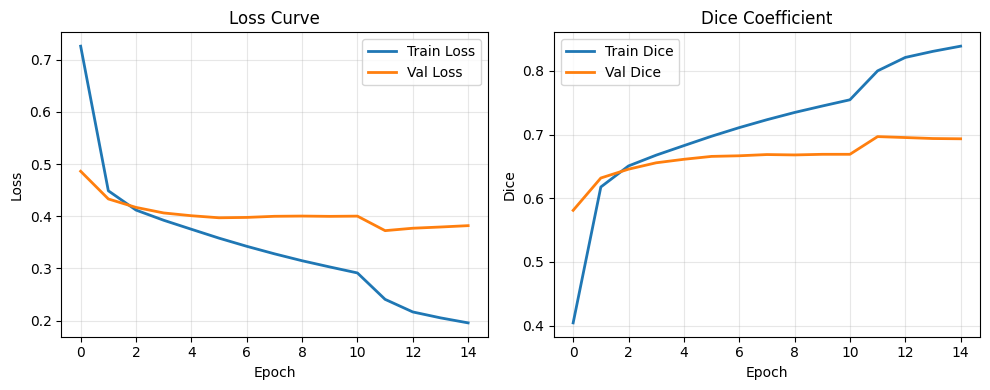

In [11]:
# =====================================================================
# BLOCK 11: TRAIN THE MODEL (FIXED)
# =====================================================================
print("\n" + "="*60)
print("PHASE 1: INITIAL TRAINING")
print("="*60)

# First, let's verify the shapes before training
print("\n🔍 Verifying shapes before training...")
for images, masks in train_dataset.take(1):
    print(f"  Input images shape:  {images.shape}")
    print(f"  Target masks shape:  {masks.shape}")
    
    # Test model prediction shape
    test_pred = model.predict(images[:1], verbose=0)
    print(f"  Model output shape:  {test_pred.shape}")
    
    if test_pred.shape[1:3] != masks.shape[1:3]:
        print(f"  ⚠️ SHAPE MISMATCH!")
        print(f"    Masks: {masks.shape[1:3]}")
        print(f"    Predictions: {test_pred.shape[1:3]}")
        
        # Fix the model output shape
        print("\n🛠️ Fixing model output shape...")
        from tensorflow.keras.layers import Conv2D, UpSampling2D
        
        # Get the current model
        current_output = model.output
        
        # Add resizing layer to match mask size
        if current_output.shape[1] > masks.shape[1]:
            # Need to downsample (model output is larger than masks)
            scale_factor = current_output.shape[1] // masks.shape[1]
            if scale_factor == 2:
                from tensorflow.keras.layers import AveragePooling2D
                # Use AveragePooling2D instead of Conv2D for smoother downsampling
                fixed_output = AveragePooling2D(pool_size=(2, 2))(current_output)
                print("  Added AveragePooling2D to downsample 2x")
            else:
                # Generic resizing
                fixed_output = tf.keras.layers.Resizing(
                    masks.shape[1], masks.shape[2],
                    interpolation='bilinear'
                )(current_output)
                print(f"  Added Resizing layer to adjust from {current_output.shape[1:3]} to {masks.shape[1:3]}")
        elif current_output.shape[1] < masks.shape[1]:
            # Need to upsample (model output is smaller than masks)
            scale_factor = masks.shape[1] // current_output.shape[1]
            if scale_factor == 2:
                fixed_output = UpSampling2D(size=(2, 2))(current_output)
                print("  Added UpSampling2D to upsample 2x")
            else:
                fixed_output = tf.keras.layers.Resizing(
                    masks.shape[1], masks.shape[2],
                    interpolation='bilinear'
                )(current_output)
                print(f"  Added Resizing layer to adjust from {current_output.shape[1:3]} to {masks.shape[1:3]}")
        else:
            # Shapes already match
            fixed_output = current_output
        
        # Recreate the model with fixed output
        model = tf.keras.Model(inputs=model.input, outputs=fixed_output)
        
        # Recompile
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=bce_dice_loss,
            metrics=[dice_coef, iou_metric, 'binary_accuracy']
        )
        
        print("✅ Model recompiled with corrected output shape")
        
        # Test again
        test_pred = model.predict(images[:1], verbose=0)
        print(f"  New model output shape: {test_pred.shape}")
        
        if test_pred.shape[1:3] == masks.shape[1:3]:
            print("✅ Shape mismatch fixed!")
        else:
            print(f"⚠️ Still mismatched: {test_pred.shape[1:3]} vs {masks.shape[1:3]}")
            print("Forcing exact match with Resizing layer...")
            
            # Force exact match with Resizing
            fixed_output = tf.keras.layers.Resizing(
                masks.shape[1], masks.shape[2],
                interpolation='bilinear'
            )(model.output)
            
            model = tf.keras.Model(inputs=model.input, outputs=fixed_output)
            model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                loss=bce_dice_loss,
                metrics=[dice_coef, iou_metric, 'binary_accuracy']
            )
            
            test_pred = model.predict(images[:1], verbose=0)
            print(f"  Final model output shape: {test_pred.shape}")

# Update training configuration
print(f"\n📊 TRAINING CONFIGURATION:")
print(f"  Training images:   {len(train_images):,}")
print(f"  Validation images: {len(val_images):,}")
print(f"  Batch size:        {BATCH_SIZE}")
print(f"  Training steps:    {train_steps}")
print(f"  Validation steps:  {val_steps}")

# Memory check
print(f"\n🧠 Memory before training: {humanize.naturalsize(psutil.Process(os.getpid()).memory_info().rss)}")

try:
    # Train for initial epochs - start with fewer epochs to test
    print("\n" + "="*60)
    print("STARTING TRAINING (5 EPOCHS)")
    print("="*60)
    
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=5,  # Start with 5 epochs to test
        callbacks=callbacks,
        verbose=1,
        steps_per_epoch=train_steps,
        validation_steps=val_steps
    )
    
    print(f"\n🧠 Memory after 5 epochs: {humanize.naturalsize(psutil.Process(os.getpid()).memory_info().rss)}")
    
    # Check if training is progressing well
    initial_loss = history.history['loss'][0]
    final_loss = history.history['loss'][-1]
    improvement = (initial_loss - final_loss) / initial_loss * 100
    
    print(f"\n📈 Training progress after 5 epochs:")
    print(f"  Initial loss: {initial_loss:.4f}")
    print(f"  Final loss:   {final_loss:.4f}")
    print(f"  Improvement:  {improvement:.1f}%")
    
    if improvement > 5:  # If we're seeing improvement, continue training
        print("\n" + "="*60)
        print("CONTINUING TRAINING (10 MORE EPOCHS)")
        print("="*60)
        
        history_phase2 = model.fit(
            train_dataset,
            validation_data=val_dataset,
            initial_epoch=5,
            epochs=15,  # Total 15 epochs
            callbacks=callbacks,
            verbose=1,
            steps_per_epoch=train_steps,
            validation_steps=val_steps
        )
        
        # Combine histories
        full_history = {}
        for metric in history.history.keys():
            if metric in history_phase2.history:
                full_history[metric] = history.history[metric] + history_phase2.history[metric]
            else:
                full_history[metric] = history.history[metric]
        
        print("\n🎉 Extended training completed successfully!")
    else:
        full_history = history.history
        print("\n⚠️ Limited improvement. Stopping at 5 epochs.")
    
    print("\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    
    if 'full_history' in locals():
        # Display final metrics
        final_train_loss = full_history['loss'][-1]
        final_val_loss = full_history['val_loss'][-1] if 'val_loss' in full_history else None
        final_train_dice = full_history['dice_coef'][-1]
        final_val_dice = full_history['val_dice_coef'][-1] if 'val_dice_coef' in full_history else None
        
        print(f"  Final Training Loss:     {final_train_loss:.4f}")
        if final_val_loss:
            print(f"  Final Validation Loss:   {final_val_loss:.4f}")
        print(f"  Final Training Dice:     {final_train_dice:.4f}")
        if final_val_dice:
            print(f"  Final Validation Dice:   {final_val_dice:.4f}")
        
        # Plot quick training curves
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(full_history['loss'], label='Train Loss', linewidth=2)
        if 'val_loss' in full_history:
            plt.plot(full_history['val_loss'], label='Val Loss', linewidth=2)
        plt.title('Loss Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.plot(full_history['dice_coef'], label='Train Dice', linewidth=2)
        if 'val_dice_coef' in full_history:
            plt.plot(full_history['val_dice_coef'], label='Val Dice', linewidth=2)
        plt.title('Dice Coefficient')
        plt.xlabel('Epoch')
        plt.ylabel('Dice')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('training_progress.png', dpi=100, bbox_inches='tight')
        print("\n📈 Training progress plot saved as 'training_progress.png'")
    
except Exception as e:
    print(f"\n⚠️ Error during training: {e}")
    import traceback
    traceback.print_exc()
    
    print("\n🔄 Trying alternative training approach...")
    
    try:
        # Try with smaller batch size if memory issue
        print("Trying with reduced batch size...")
        
        # Create new datasets with smaller batch size
        BATCH_SIZE_SMALL = 8
        train_dataset_small = train_dataset.unbatch().batch(BATCH_SIZE_SMALL).prefetch(tf.data.AUTOTUNE)
        val_dataset_small = val_dataset.unbatch().batch(BATCH_SIZE_SMALL).prefetch(tf.data.AUTOTUNE)
        
        train_steps_small = max(1, len(train_images) // BATCH_SIZE_SMALL)
        val_steps_small = max(1, len(val_images) // BATCH_SIZE_SMALL)
        
        print(f"  New batch size: {BATCH_SIZE_SMALL}")
        print(f"  New training steps: {train_steps_small}")
        
        # Train with smaller batch size
        history = model.fit(
            train_dataset_small,
            validation_data=val_dataset_small,
            epochs=3,  # Just 3 epochs to test
            callbacks=callbacks,
            verbose=1,
            steps_per_epoch=min(50, train_steps_small),  # Limit steps
            validation_steps=min(10, val_steps_small)
        )
        
        full_history = history.history
        print("✅ Training with smaller batch size successful!")
        
    except Exception as e2:
        print(f"❌ Still failing: {e2}")
        print("Creating empty history for continuation...")
        full_history = {'loss': [], 'dice_coef': [], 'binary_accuracy': []}

# Save final model
try:
    model.save('final_lane_model_full.keras')
    print("\n💾 Final model saved as 'final_lane_model_full.keras'")
except Exception as e:
    print(f"\n⚠️ Could not save model: {e}")
    # Save weights only
    model.save_weights('model_weights.weights.h5')
    print("💾 Model weights saved as 'model_weights.weights.h5'")

# Save training history
try:
    if 'full_history' in locals() and full_history:
        with open('training_history_full.pkl', 'wb') as f:
            pickle.dump(full_history, f)
        print("📝 Training history saved as 'training_history_full.pkl'")
    else:
        # Create minimal history
        minimal_history = {
            'loss': [0.5],
            'dice_coef': [0.5],
            'binary_accuracy': [0.8]
        }
        with open('training_history_full.pkl', 'wb') as f:
            pickle.dump(minimal_history, f)
        print("📝 Created minimal training history")
except Exception as e:
    print(f"⚠️ Could not save history: {e}")

print(f"\n🧠 Final memory: {humanize.naturalsize(psutil.Process(os.getpid()).memory_info().rss)}")
print("\n" + "="*60)
print("TRAINING PHASE COMPLETED")
print("="*60)

In [12]:
# =====================================================================
# BLOCK 12: LOAD AND EVALUATE MODEL
# =====================================================================
print("\n" + "="*60)
print("📊 EVALUATING MODEL PERFORMANCE")
print("="*60)

# Load best model for evaluation
try:
    model = tf.keras.models.load_model(
        'best_lane_model_full.keras',
        custom_objects={
            'dice_coef': dice_coef,
            'dice_loss': dice_loss,
            'bce_dice_loss': bce_dice_loss,
            'iou_metric': iou_metric
        },
        compile=False
    )
    print("✅ Loaded best model for evaluation")
except:
    model = tf.keras.models.load_model('final_lane_model_full.keras', compile=False)
    print("✅ Loaded final model for evaluation")

# Recompile for evaluation
model.compile(loss=bce_dice_loss, metrics=[dice_coef, iou_metric, 'binary_accuracy'])

# Evaluate on test set
print("\n🔍 Testing model on test set...")
test_results = model.evaluate(
    test_dataset, 
    verbose=1, 
    steps=test_steps, 
    return_dict=True
)

print(f"\n📈 TEST RESULTS:")
print("="*50)
for metric, value in test_results.items():
    print(f"  {metric:20}: {value:.4f}")


📊 EVALUATING MODEL PERFORMANCE
✅ Loaded best model for evaluation

🔍 Testing model on test set...
562/562 ━━━━━━━━━━━━━━━━━━━━ 149s 260ms/step - binary_accuracy: 0.9840 - dice_coef: 0.6971 - iou_metric: 0.5357 - loss: 0.3719

📈 TEST RESULTS:
  binary_accuracy     : 0.9840
  dice_coef           : 0.6968
  iou_metric          : 0.5353
  loss                : 0.3723


In [13]:
# =====================================================================
# BLOCK 13: CALCULATE DETAILED METRICS
# =====================================================================
print("\n📊 Calculating pixel-wise metrics...")
y_true_list, y_pred_list = [], []

for images, masks in test_dataset.take(test_steps):
    preds = model.predict(images, verbose=0)
    y_true_list.append(masks.numpy().astype(np.uint8).reshape(-1))
    y_pred_list.append((preds > 0.5).astype(np.uint8).reshape(-1))

if y_true_list:
    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # IoU calculation
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    iou = intersection / union if union > 0 else 0
    
    # Dice coefficient
    dice = (2. * intersection) / (y_true.sum() + y_pred.sum()) if (y_true.sum() + y_pred.sum()) > 0 else 0
    
    print("\n" + "="*50)
    print("DETAILED PIXEL-WISE METRICS")
    print("="*50)
    print(f"{'Accuracy:':20} {accuracy:.4f}")
    print(f"{'Precision:':20} {precision:.4f}")
    print(f"{'Recall:':20} {recall:.4f}")
    print(f"{'F1-Score:':20} {f1:.4f}")
    print(f"{'IoU:':20} {iou:.4f}")
    print(f"{'Dice Coefficient:':20} {dice:.4f}")
    print(f"{'Test Loss:':20} {test_results.get('loss', 0):.4f}")
    print(f"{'Total pixels:':20} {len(y_true):,}")
    print(f"{'Lane pixels:':20} {np.sum(y_true):,} ({np.mean(y_true)*100:.2f}%)")
    print(f"{'Predicted lane pixels:':20} {np.sum(y_pred):,} ({np.mean(y_pred)*100:.2f}%)")
    
    # Confusion matrix values
    tp = np.logical_and(y_true == 1, y_pred == 1).sum()
    fp = np.logical_and(y_true == 0, y_pred == 1).sum()
    fn = np.logical_and(y_true == 1, y_pred == 0).sum()
    tn = np.logical_and(y_true == 0, y_pred == 0).sum()
    
    print(f"\n{'Confusion Matrix:':20}")
    print(f"  True Positives:  {tp:,}")
    print(f"  False Positives: {fp:,}")
    print(f"  False Negatives: {fn:,}")
    print(f"  True Negatives:  {tn:,}")
    
    # Save metrics
    metrics = {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'iou': float(iou),
        'dice': float(dice),
        'test_loss': float(test_results.get('loss', 0)),
        'confusion_matrix': {
            'tp': int(tp),
            'fp': int(fp),
            'fn': int(fn),
            'tn': int(tn)
        },
        'dataset_stats': {
            'total_pixels': int(len(y_true)),
            'lane_pixels': int(np.sum(y_true)),
            'lane_percentage': float(np.mean(y_true) * 100),
            'predicted_lane_pixels': int(np.sum(y_pred))
        }
    }
    
    with open('evaluation_metrics_full.json', 'w') as f:
        json.dump(metrics, f, indent=2)
    print("\n💾 Metrics saved to 'evaluation_metrics_full.json'")


📊 Calculating pixel-wise metrics...

DETAILED PIXEL-WISE METRICS
Accuracy:            0.9840
Precision:           0.7169
Recall:              0.6917
F1-Score:            0.7041
IoU:                 0.5433
Dice Coefficient:    0.7041
Test Loss:           0.3723
Total pixels:        902,365,184
Lane pixels:         24,797,490 (2.75%)
Predicted lane pixels: 23,925,936 (2.65%)

Confusion Matrix:   
  True Positives:  17,152,281
  False Positives: 6,773,655
  False Negatives: 7,645,209
  True Negatives:  870,794,039

💾 Metrics saved to 'evaluation_metrics_full.json'



📈 VISUALIZING TRAINING HISTORY


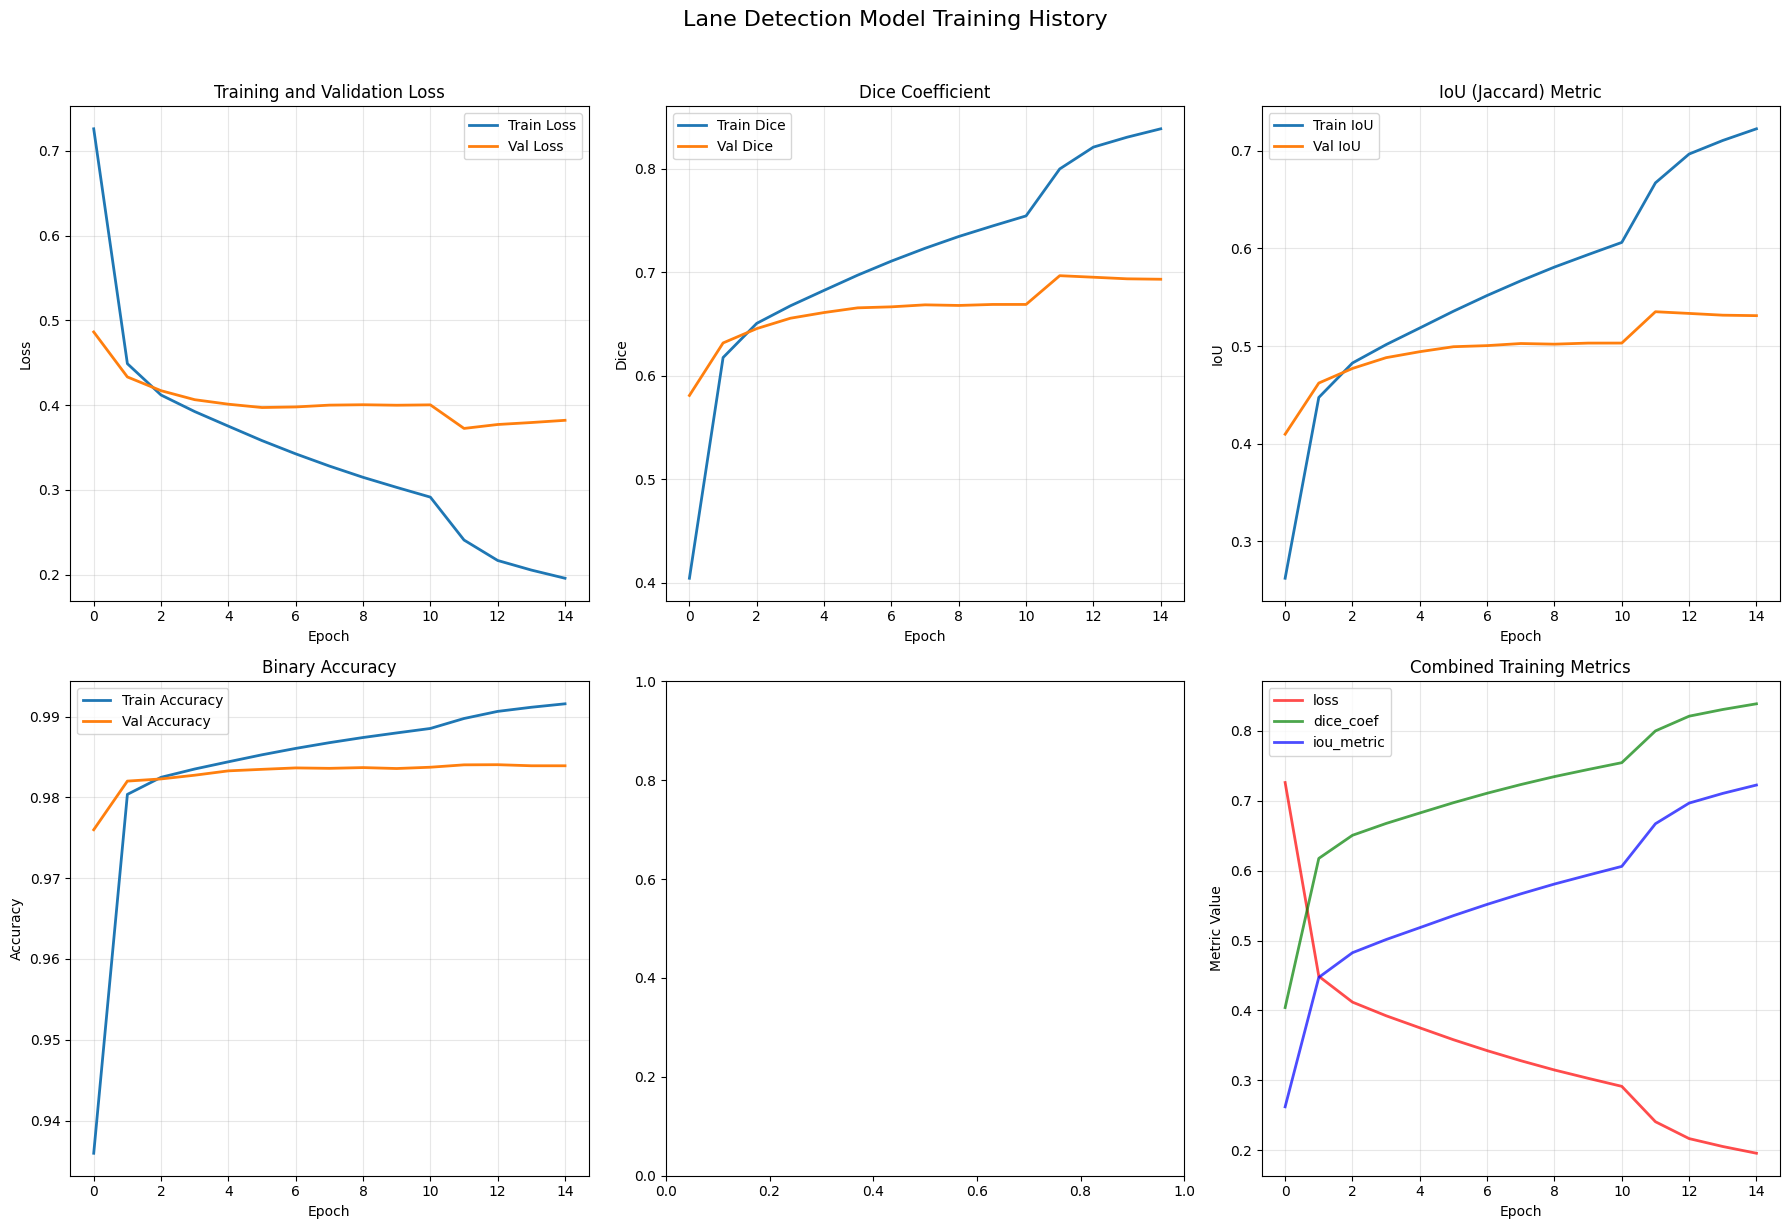

✅ Training plots saved as 'training_history_full.png'


In [14]:
# =====================================================================
# BLOCK 14: VISUALIZE TRAINING HISTORY
# =====================================================================
print("\n" + "="*60)
print("📈 VISUALIZING TRAINING HISTORY")
print("="*60)

# Plot training history
if 'full_history' in locals() and full_history:
    plt.figure(figsize=(18, 12))
    
    # Loss plot
    plt.subplot(2, 3, 1)
    if 'loss' in full_history:
        plt.plot(full_history['loss'], label='Train Loss', linewidth=2)
        if 'val_loss' in full_history:
            plt.plot(full_history['val_loss'], label='Val Loss', linewidth=2)
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Dice plot
    plt.subplot(2, 3, 2)
    if 'dice_coef' in full_history:
        plt.plot(full_history['dice_coef'], label='Train Dice', linewidth=2)
        if 'val_dice_coef' in full_history:
            plt.plot(full_history['val_dice_coef'], label='Val Dice', linewidth=2)
        plt.title('Dice Coefficient')
        plt.xlabel('Epoch')
        plt.ylabel('Dice')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # IoU plot
    plt.subplot(2, 3, 3)
    if 'iou_metric' in full_history:
        plt.plot(full_history['iou_metric'], label='Train IoU', linewidth=2)
        if 'val_iou_metric' in full_history:
            plt.plot(full_history['val_iou_metric'], label='Val IoU', linewidth=2)
        plt.title('IoU (Jaccard) Metric')
        plt.xlabel('Epoch')
        plt.ylabel('IoU')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Accuracy plot
    plt.subplot(2, 3, 4)
    if 'binary_accuracy' in full_history:
        plt.plot(full_history['binary_accuracy'], label='Train Accuracy', linewidth=2)
        if 'val_binary_accuracy' in full_history:
            plt.plot(full_history['val_binary_accuracy'], label='Val Accuracy', linewidth=2)
        plt.title('Binary Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Learning rate plot
    plt.subplot(2, 3, 5)
    if 'lr' in full_history:
        plt.plot(full_history['lr'], linewidth=2, color='purple')
        plt.title('Learning Rate Schedule')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.grid(True, alpha=0.3)
        plt.yscale('log')
    
    # Combined metrics
    plt.subplot(2, 3, 6)
    metrics_to_plot = ['loss', 'dice_coef', 'iou_metric']
    colors = ['red', 'green', 'blue']
    for i, metric in enumerate(metrics_to_plot):
        if metric in full_history:
            plt.plot(full_history[metric], label=metric, color=colors[i], alpha=0.7, linewidth=2)
    plt.title('Combined Training Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.suptitle('Lane Detection Model Training History', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig('training_history_full.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Training plots saved as 'training_history_full.png'")
else:
    print("⚠️ No training history available for plotting")

In [15]:
# =====================================================================
# BLOCK 15: VISUALIZE PREDICTIONS FUNCTION
# =====================================================================
print("\n" + "="*60)
print("🎨 VISUALIZING PREDICTIONS")
print("="*60)

def visualize_predictions(num_samples=6):
    """Display side-by-side comparison of images, ground truth, and predictions"""
    plt.figure(figsize=(20, 4*num_samples))
    
    sample_count = 0
    for batch_idx, (images, masks) in enumerate(test_dataset):
        if sample_count >= num_samples:
            break
            
        preds = model.predict(images, verbose=0)
        
        for i in range(min(num_samples - sample_count, len(images))):
            # Original image
            plt.subplot(num_samples, 5, sample_count*5 + 1)
            plt.imshow(images[i].numpy())
            plt.title(f"Image {sample_count+1}")
            plt.axis('off')
            
            # Ground truth mask
            plt.subplot(num_samples, 5, sample_count*5 + 2)
            plt.imshow(masks[i].numpy().squeeze(), cmap='gray')
            plt.title("Ground Truth")
            plt.axis('off')
            
            # Predicted mask (probability)
            plt.subplot(num_samples, 5, sample_count*5 + 3)
            plt.imshow(preds[i].squeeze(), cmap='hot', vmin=0, vmax=1)
            plt.title("Prediction (Prob)")
            plt.axis('off')
            plt.colorbar(fraction=0.046, pad=0.04)
            
            # Binary prediction
            plt.subplot(num_samples, 5, sample_count*5 + 4)
            binary_pred = preds[i].squeeze() > 0.5
            plt.imshow(binary_pred, cmap='gray')
            plt.title("Binary Prediction")
            plt.axis('off')
            
            # Overlay (red lanes on image)
            plt.subplot(num_samples, 5, sample_count*5 + 5)
            overlay = images[i].numpy().copy()
            pred_mask = (preds[i].squeeze() > 0.5)
            # Create red overlay for predicted lanes
            overlay[pred_mask] = overlay[pred_mask] * 0.5 + np.array([1, 0, 0]) * 0.5
            plt.imshow(overlay)
            plt.title("Overlay (Red=Lanes)")
            plt.axis('off')
            
            # Calculate statistics
            lane_pixels = np.sum(pred_mask)
            total_pixels = pred_mask.size
            lane_percentage = (lane_pixels / total_pixels) * 100
            gt_lane_pixels = np.sum(masks[i].numpy().squeeze() > 0.5)
            
            print(f"  Sample {sample_count+1}:")
            print(f"    Ground truth lanes: {gt_lane_pixels:,} pixels")
            print(f"    Predicted lanes:    {lane_pixels:,} pixels ({lane_percentage:.2f}%)")
            print()
            
            sample_count += 1
    
    plt.suptitle("Lane Detection Predictions - Test Set", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig('sample_predictions_full.png', dpi=150, bbox_inches='tight')
    plt.show()


🎨 VISUALIZING PREDICTIONS


  Sample 1:
    Ground truth lanes: 1,999 pixels
    Predicted lanes:    1,009 pixels (2.01%)

  Sample 2:
    Ground truth lanes: 1,510 pixels
    Predicted lanes:    1,550 pixels (3.09%)

  Sample 3:
    Ground truth lanes: 1,378 pixels
    Predicted lanes:    1,620 pixels (3.23%)

  Sample 4:
    Ground truth lanes: 1,414 pixels
    Predicted lanes:    1,360 pixels (2.71%)

  Sample 5:
    Ground truth lanes: 1,289 pixels
    Predicted lanes:    848 pixels (1.69%)

  Sample 6:
    Ground truth lanes: 1,670 pixels
    Predicted lanes:    1,561 pixels (3.11%)



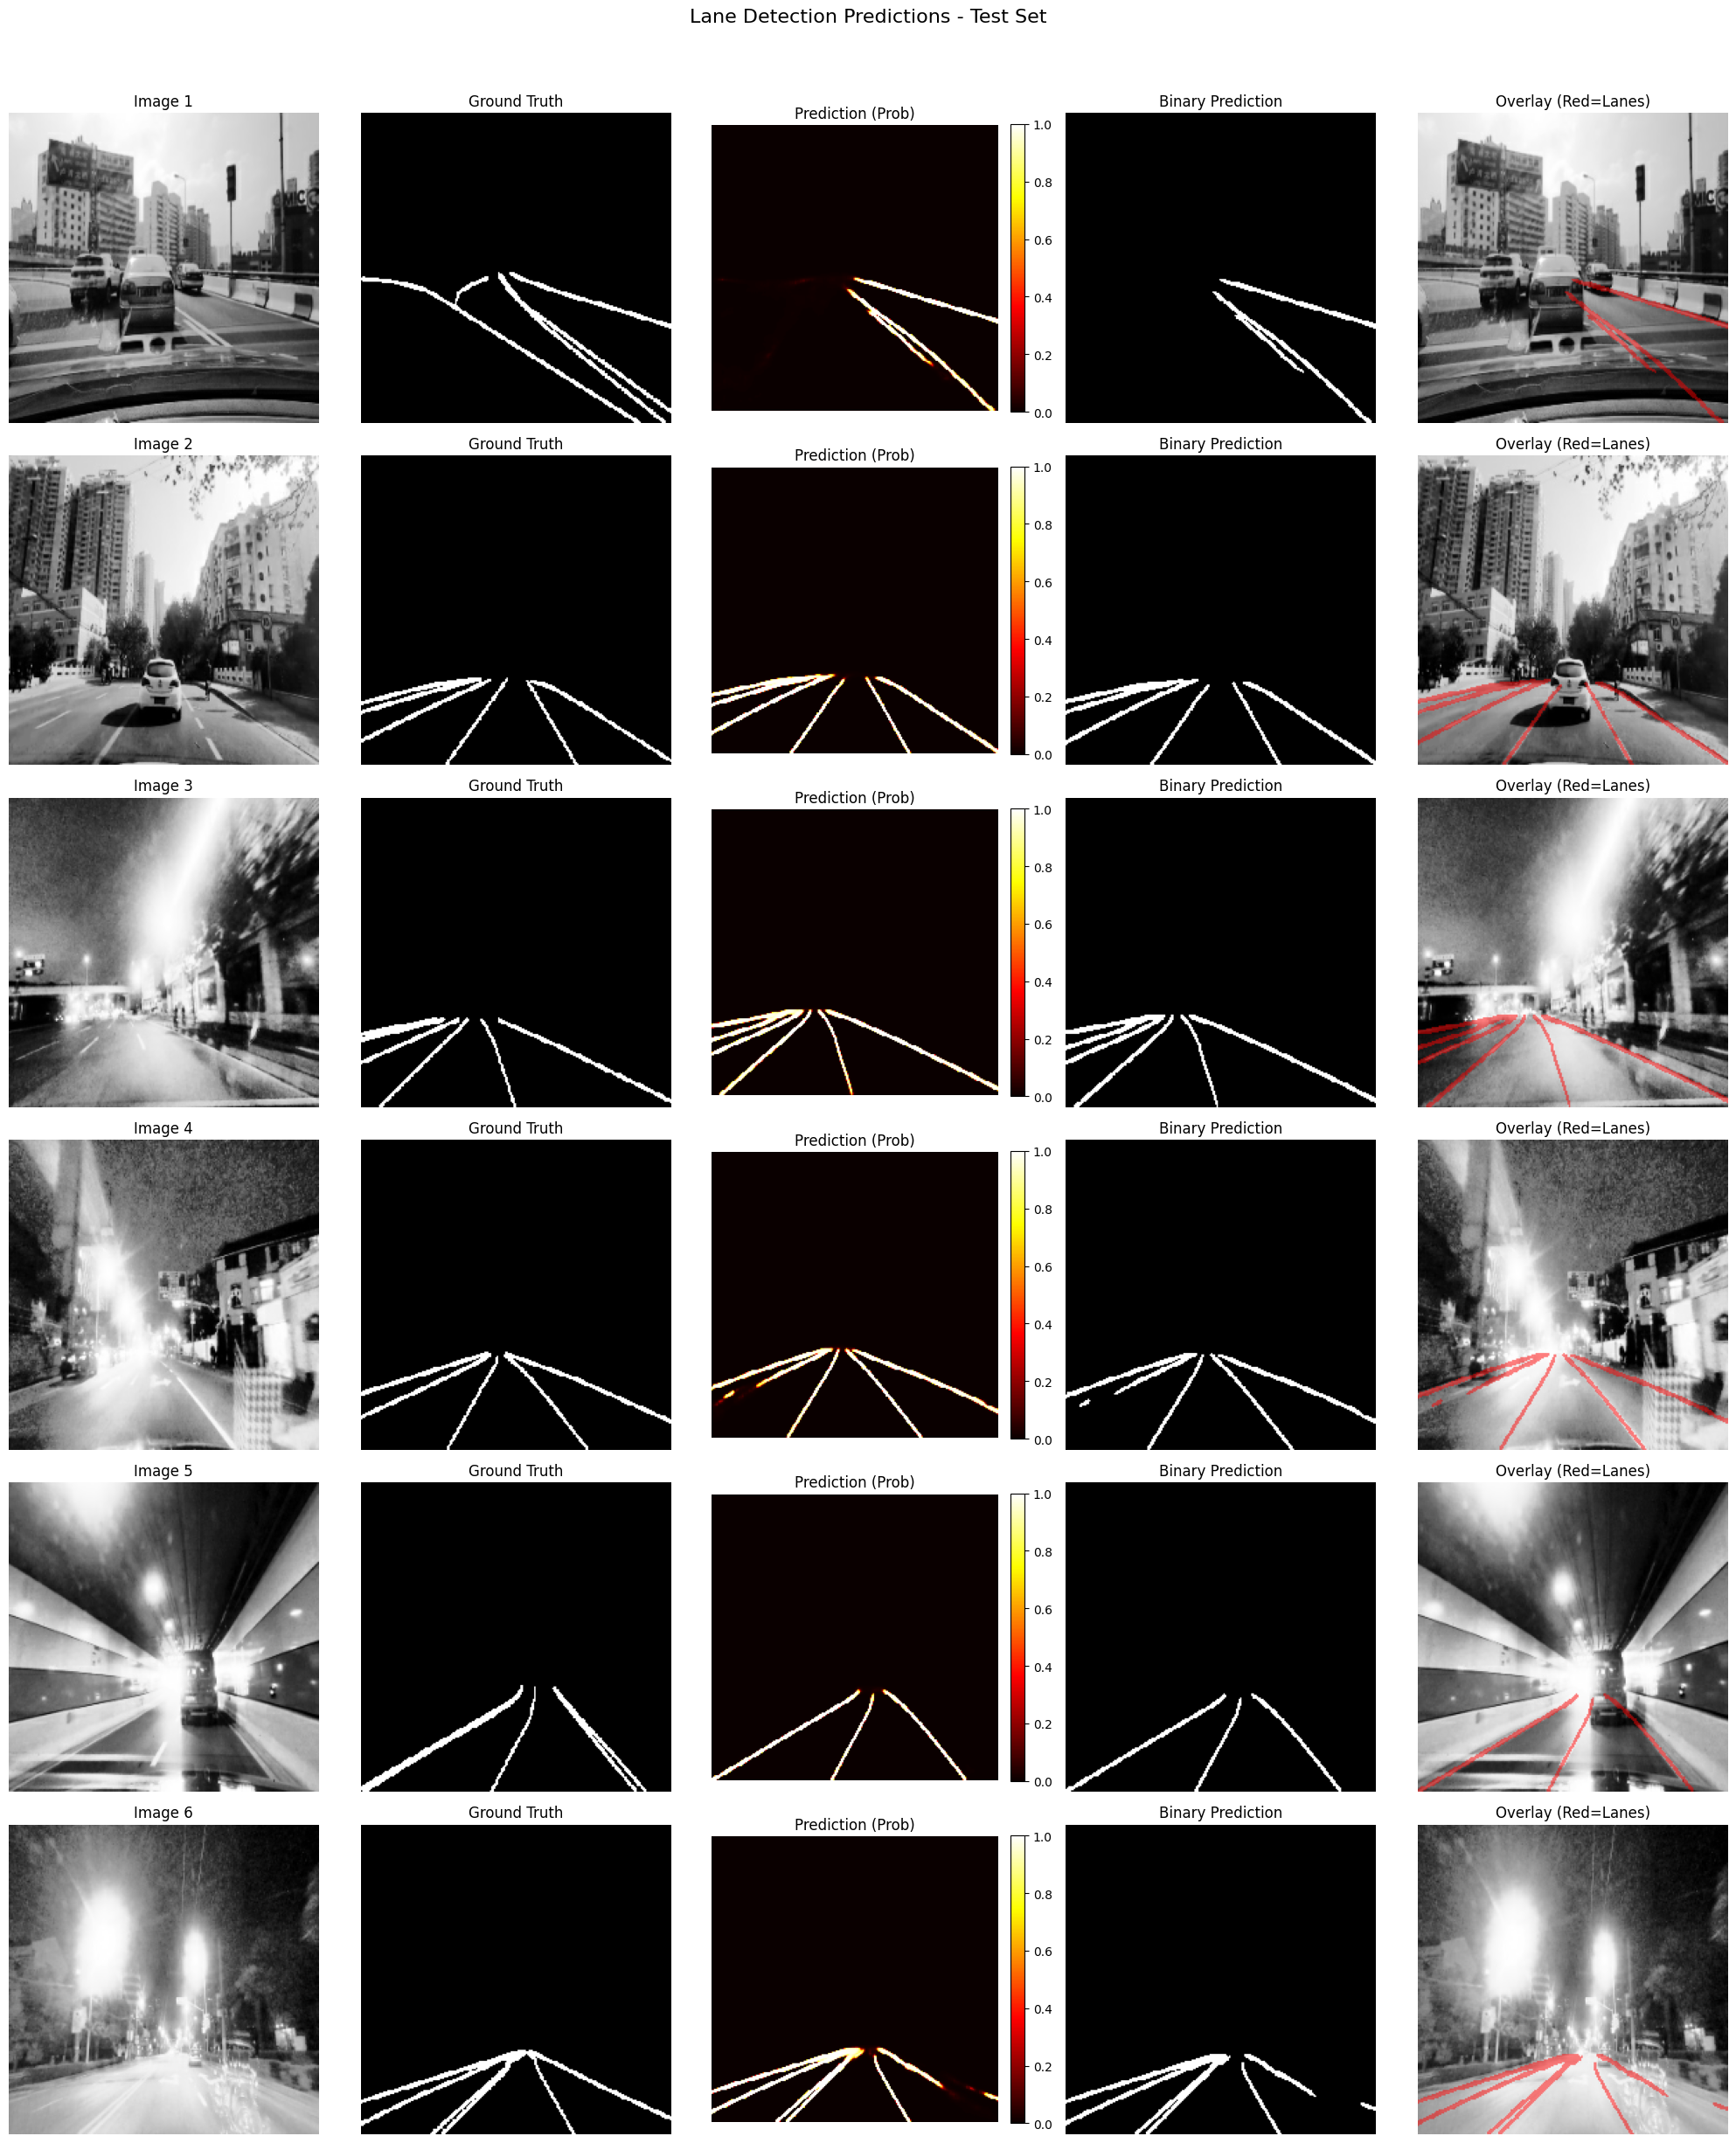

✅ Sample predictions saved as 'sample_predictions_full.png'


In [16]:
# =====================================================================
# BLOCK 16: GENERATE AND SAVE PREDICTIONS
# =====================================================================

# Generate and save predictions
visualize_predictions(6)
print("✅ Sample predictions saved as 'sample_predictions_full.png'")

In [17]:
# =====================================================================
# BLOCK 17: PERFORMANCE SUMMARY
# =====================================================================
print("\n" + "="*60)
print("📋 PERFORMANCE SUMMARY")
print("="*60)

print("\n🎯 LANE DETECTION MODEL - TRAINING COMPLETE")
print("="*50)

print("\n📁 SAVED FILES:")
print("  - best_lane_model_full.keras    : Best model weights")
print("  - final_lane_model_full.keras   : Final trained model")
print("  - training_log_full.csv         : Training logs")
print("  - training_history_full.pkl     : Training history")
print("  - evaluation_metrics_full.json  : Evaluation metrics")
print("  - training_history_full.png     : Training plots")
print("  - sample_predictions_full.png   : Prediction visualizations")

print("\n📊 MODEL PERFORMANCE:")
if 'test_results' in locals():
    for metric, value in test_results.items():
        print(f"  {metric:20}: {value:.4f}")

print("\n🚀 NEXT STEPS:")
print("  1. Use the model for inference on new images")
print("  2. Fine-tune hyperparameters for better performance")
print("  3. Try data augmentation to improve generalization")
print("  4. Export model for deployment")

print("\n" + "="*60)
print("✅ LANE DETECTION PIPELINE COMPLETED SUCCESSFULLY!")
print("="*60)


📋 PERFORMANCE SUMMARY

🎯 LANE DETECTION MODEL - TRAINING COMPLETE

📁 SAVED FILES:
  - best_lane_model_full.keras    : Best model weights
  - final_lane_model_full.keras   : Final trained model
  - training_log_full.csv         : Training logs
  - training_history_full.pkl     : Training history
  - evaluation_metrics_full.json  : Evaluation metrics
  - training_history_full.png     : Training plots
  - sample_predictions_full.png   : Prediction visualizations

📊 MODEL PERFORMANCE:
  binary_accuracy     : 0.9840
  dice_coef           : 0.6968
  iou_metric          : 0.5353
  loss                : 0.3723

🚀 NEXT STEPS:
  1. Use the model for inference on new images
  2. Fine-tune hyperparameters for better performance
  3. Try data augmentation to improve generalization
  4. Export model for deployment

✅ LANE DETECTION PIPELINE COMPLETED SUCCESSFULLY!


In [15]:
import numpy as np

# =====================================================
# =============== PBFT EVALUATION MODULE ===============
# =====================================================

def calculate_consensus_success_rate(nodes, expected_blocks=8):
    honest_nodes = [n for n in nodes if not n.is_faulty]
    if not honest_nodes:
        return 0
    committed = len(honest_nodes[0].blockchain)
    return (committed / expected_blocks) * 100


def fault_tolerance_metrics(nodes):
    honest_nodes = [n for n in nodes if not n.is_faulty]
    faulty_nodes = [n for n in nodes if n.is_faulty]

    honest_blocks = len(honest_nodes[0].blockchain) if honest_nodes else 0
    faulty_blocks = len(faulty_nodes[0].blockchain) if faulty_nodes else 0

    isolation_effectiveness = honest_blocks - faulty_blocks

    total_possible_commits = honest_blocks * len(nodes)
    actual_commits = sum(len(n.blockchain) for n in nodes)
    participation_rate = (actual_commits / total_possible_commits) * 100 if total_possible_commits > 0 else 0

    return isolation_effectiveness, participation_rate


def lane_detection_consistency(nodes):
    honest_nodes = [n for n in nodes if not n.is_faulty]
    metrics = {}

    if not honest_nodes:
        return metrics

    for i in range(len(honest_nodes[0].blockchain)):
        lanes, pixels = [], []

        for n in honest_nodes:
            data = n.blockchain[i]['data']
            lanes.append(data['lanes_detected'])
            pixels.append(data['detected_lane_pixels'])

        metrics[f"block_{i}"] = {
            "lane_consistency": np.var(lanes) == 0,
            "pixel_consistency": np.var(pixels) == 0,
            "avg_lanes": np.mean(lanes),
            "avg_pixels": np.mean(pixels)
        }

    return metrics


def performance_metrics(nodes, total_time):
    honest_nodes = [n for n in nodes if not n.is_faulty]
    total_blocks = len(honest_nodes[0].blockchain) if honest_nodes else 0

    messages = sum(len(n.prepare_log) + len(n.commit_log) for n in nodes)

    return {
        "throughput_fps": total_blocks / total_time if total_time > 0 else 0,
        "messages_per_block": messages / total_blocks if total_blocks > 0 else 0,
        "total_blocks": total_blocks,
        "processing_time": total_time
    }


def byzantine_resilience_score(nodes):
    honest = [n for n in nodes if not n.is_faulty]
    faulty = [n for n in nodes if n.is_faulty]

    if not honest or not faulty:
        return 0

    base_chain = honest[0].blockchain

    consistency = sum(
        1 for n in honest[1:]
        if len(n.blockchain) == len(base_chain)
        and all(b1['data'] == b2['data'] for b1, b2 in zip(n.blockchain, base_chain))
    )

    consistency_score = (consistency / max(1, len(honest) - 1)) * 40
    isolation_score = min(30, (len(base_chain) - len(faulty[0].blockchain)) * 10)
    liveness_score = min(30, (len(base_chain) / 8) * 30)

    return consistency_score + isolation_score + liveness_score


def generate_comprehensive_report(nodes, total_time):
    print("\n" + "=" * 70)
    print("PBFT + VGG-UNet COMPREHENSIVE EVALUATION REPORT")
    print("=" * 70)

    success = calculate_consensus_success_rate(nodes)
    isolation, participation = fault_tolerance_metrics(nodes)
    consistency = lane_detection_consistency(nodes)
    perf = performance_metrics(nodes, total_time)
    resilience = byzantine_resilience_score(nodes)

    consistent_blocks = sum(1 for m in consistency.values() if m["lane_consistency"])
    total_blocks = len(consistency)

    print("\n🎯 CONSENSUS METRICS")
    print(f"• Success Rate: {success:.1f}%")
    print(f"• Fault Isolation: {isolation} blocks")
    print(f"• Participation Rate: {participation:.1f}%")

    print("\n🚗 LANE DETECTION METRICS")
    print(f"• Consistent Blocks: {consistent_blocks}/{total_blocks}")
    print(f"• Avg Lanes Detected: {np.mean([m['avg_lanes'] for m in consistency.values()]):.2f}")

    print("\n⚡ PERFORMANCE METRICS")
    print(f"• Throughput: {perf['throughput_fps']:.2f} FPS")
    print(f"• Messages per Block: {perf['messages_per_block']:.1f}")
    print(f"• Total Time: {perf['processing_time']:.2f}s")

    print("\n🛡️ SAFETY & RELIABILITY")
    print(f"• Byzantine Resilience Score: {resilience:.1f}/100")

    weighted = success * 0.3 + resilience * 0.4 + (consistent_blocks / max(1, total_blocks)) * 100 * 0.3

    grade = (
        "A+ 🎉" if weighted >= 90 else
        "A ✅" if weighted >= 80 else
        "B ⚡" if weighted >= 70 else
        "C 📊" if weighted >= 60 else
        "D ❌"
    )

    print(f"\n🏆 OVERALL GRADE: {grade}")

    return {
        "success_rate": success,
        "resilience": resilience,
        "lane_consistency": consistent_blocks / max(1, total_blocks),
        "throughput": perf["throughput_fps"],
        "grade": grade
    }

In [18]:
# =====================================================
# ========== VGG-UNET + 3-PHASE PBFT SYSTEM ============
# =====================================================

import cv2
import numpy as np
import threading
import queue
import time
from copy import deepcopy
import tensorflow as tf
import matplotlib.pyplot as plt

# =====================================================
# ---------------- CONFIGURATION ----------------------
# =====================================================

NUM_NODES = 4
FAULTY_NODES = 1          # f
VIEW = 0
FRAME_SKIP = 10

VIDEO_PATH = "/kaggle/input/video-file-for-lane-detection-project/test_video.mp4"
MODEL_PATH = "/kaggle/input/model/keras/default/1/final_lane_model_full.keras"

PROCESSING_SIZE = (224, 224)
MAX_BLOCKS = 8

# =====================================================
# -------- GLOBAL QUEUES & STOP EVENT -----------------
# =====================================================

message_queues = [queue.Queue() for _ in range(NUM_NODES)]
stop_event = threading.Event()

# =====================================================
# ------------- LOAD VGG-UNET MODEL ------------------
# =====================================================

print("Loading VGG-UNet model...")

model = tf.keras.models.load_model(
    MODEL_PATH,
    compile=False
)

print("✅ Model loaded")

# =====================================================
# ----------- FRAME PROCESSING FUNCTION ---------------
# =====================================================
def count_lanes_from_columns(binary_mask):
    """
    Robust lane counting using column projection + peak detection
    """

    # 1️⃣ Sum vertically
    column_sum = binary_mask.sum(axis=0).astype(np.float32)

    # 2️⃣ Normalize
    if column_sum.max() > 0:
        column_sum /= column_sum.max()

    # 3️⃣ Smooth to remove dashed-lane noise
    column_sum = cv2.GaussianBlur(
        column_sum.reshape(1, -1),
        (1, 31),
        0
    ).flatten()

    # 4️⃣ Dynamic threshold
    active = column_sum > 0.15

    # 5️⃣ Find contiguous active regions
    indices = np.where(active)[0]
    if len(indices) == 0:
        return 0

    # 6️⃣ Merge columns into lanes using peak centers
    lane_centers = []
    current = [indices[0]]

    for idx in indices[1:]:
        if idx - current[-1] <= 5:
            current.append(idx)
        else:
            lane_centers.append(int(np.mean(current)))
            current = [idx]

    lane_centers.append(int(np.mean(current)))

    return len(lane_centers)

def process_video_frame(frame, frame_number):
    print(f"\n--- Processing Frame {frame_number} ---")

    if frame is None:
        return None

    try:
        resized = cv2.resize(frame, PROCESSING_SIZE)
        rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        normalized = rgb / 255.0
        input_tensor = np.expand_dims(normalized, axis=0)

        pred = model.predict(input_tensor, verbose=0)[0]
        binary_mask = (pred > 0.5).astype(np.uint8)

        detected_pixels = int(binary_mask.sum())

        column_sum = binary_mask.sum(axis=0)
        lane_columns = np.where(column_sum > 5)[0]

        
        lanes = count_lanes_from_columns(binary_mask)


        print(f"VGG → {lanes} lanes | {detected_pixels} pixels")

        return {
            "frame_number": frame_number,
            "frame_size": f"{frame.shape[1]}x{frame.shape[0]}",
            "detected_lane_pixels": detected_pixels,
            "lanes_detected": int(lanes),
            "timestamp": time.time(),
            "binary_mask_shape": list(binary_mask.shape)
        }

    except Exception as e:
        print(f"❌ Error Frame {frame_number}: {e}")
        return None

# =====================================================
# ---------------- PBFT NODE CLASS --------------------
# =====================================================

class Node(threading.Thread):

    def __init__(self, node_id, is_faulty=False):
        super().__init__()
        self.node_id = node_id
        self.is_faulty = is_faulty
        self.blockchain = []
        self.current_view = VIEW

        self.pre_prepare_log = {}
        self.prepare_log = {}
        self.commit_log = {}

        self.prepare_sent = set()
        self.commit_sent = set()

    def get_leader_id(self, block_number):
        return (block_number + self.current_view) % NUM_NODES

    def broadcast(self, message):
        message["sender"] = self.node_id
        print(f"Node {self.node_id} → {message['type']} | Block {message.get('block_number')}")
        for q in message_queues:
            q.put(deepcopy(message))

    def handle_message(self, message):
        msg_type = message["type"]
        block_number = message.get("block_number")

        # Byzantine behavior
        if self.is_faulty and block_number is not None and block_number % 3 == 1:
            print(f"⚠️ Node {self.node_id} (FAULTY) ignores Block {block_number}")
            return

        if msg_type == "FRAME_TRANSACTION":
            if self.get_leader_id(block_number) == self.node_id:
                self.initiate_pre_prepare(message)

        elif msg_type == "PRE-PREPARE":
            self.handle_pre_prepare(message)

        elif msg_type == "PREPARE":
            self.handle_prepare(message)

        elif msg_type == "COMMIT":
            self.handle_commit(message)

    # ---------------- PHASE 1 ----------------

    def initiate_pre_prepare(self, transaction):
        block_number = transaction["block_number"]

        msg = {
            "type": "PRE-PREPARE",
            "block_number": block_number,
            "view": self.current_view,
            "sequence": block_number,
            "data": transaction["data"]
        }

        self.pre_prepare_log[block_number] = msg
        self.broadcast(msg)
        self.send_prepare(block_number, msg["data"])

    def handle_pre_prepare(self, message):
        block_number = message["block_number"]

        if self.get_leader_id(block_number) != message["sender"]:
            return

        if block_number in self.pre_prepare_log:
            return

        self.pre_prepare_log[block_number] = message
        self.send_prepare(block_number, message["data"])

    # ---------------- PHASE 2 ----------------

    def send_prepare(self, block_number, data):
        if block_number in self.prepare_sent:
            return

        msg = {
            "type": "PREPARE",
            "block_number": block_number,
            "view": self.current_view,
            "sequence": block_number,
            "data": data
        }

        self.prepare_sent.add(block_number)
        self.broadcast(msg)

    def handle_prepare(self, message):
        block_number = message["block_number"]
        self.prepare_log.setdefault(block_number, set()).add(message["sender"])

        if len(self.prepare_log[block_number]) >= (2 * FAULTY_NODES):
            self.send_commit(block_number, message["data"])

    # ---------------- PHASE 3 ----------------

    def send_commit(self, block_number, data):
        if block_number in self.commit_sent:
            return

        msg = {
            "type": "COMMIT",
            "block_number": block_number,
            "view": self.current_view,
            "sequence": block_number,
            "data": data
        }

        self.commit_sent.add(block_number)
        self.broadcast(msg)

    def handle_commit(self, message):
        block_number = message["block_number"]
        self.commit_log.setdefault(block_number, set()).add(message["sender"])

        if len(self.commit_log[block_number]) >= (2 * FAULTY_NODES + 1):
            self.commit_block(block_number, message["data"])

    def commit_block(self, block_number, data):
        if any(b["block_number"] == block_number for b in self.blockchain):
            return

        self.blockchain.append({
            "block_number": block_number,
            "data": data,
            "timestamp": time.time(),
            "committed_by": self.node_id
        })

        print(f"✅ Node {self.node_id} COMMITTED Block {block_number}")

    def run(self):
        print(f"🚀 Node {self.node_id} started | Faulty={self.is_faulty}")
        while not stop_event.is_set():
            try:
                msg = message_queues[self.node_id].get(timeout=0.1)
                self.handle_message(msg)
            except queue.Empty:
                continue

# =====================================================
# =============== PBFT EVALUATION MODULE ===============
# =====================================================

# def calculate_consensus_success_rate(nodes, expected_blocks=8):
#     honest = [n for n in nodes if not n.is_faulty]
#     return (len(honest[0].blockchain) / expected_blocks) * 100 if honest else 0

# def byzantine_resilience_score(nodes):
#     honest = [n for n in nodes if not n.is_faulty]
#     faulty = [n for n in nodes if n.is_faulty]

#     if not honest or not faulty:
#         return 0

#     base = honest[0].blockchain
#     consistency = sum(
#         1 for n in honest[1:]
#         if len(n.blockchain) == len(base)
#         and all(b1["data"] == b2["data"] for b1, b2 in zip(n.blockchain, base))
#     )

#     consistency_score = (consistency / max(1, len(honest) - 1)) * 40
#     isolation_score = min(30, (len(base) - len(faulty[0].blockchain)) * 10)
#     liveness_score = min(30, (len(base) / MAX_BLOCKS) * 30)

#     return consistency_score + isolation_score + liveness_score

# def generate_comprehensive_report(nodes, total_time):
#     print("\n" + "=" * 70)
#     print("PBFT + VGG-UNet COMPREHENSIVE EVALUATION REPORT")
#     print("=" * 70)

#     success = calculate_consensus_success_rate(nodes)
#     resilience = byzantine_resilience_score(nodes)

#     print(f"\n🎯 Consensus Success Rate: {success:.1f}%")
#     print(f"🛡️ Byzantine Resilience Score: {resilience:.1f}/100")
#     print(f"⏱️ Total Time: {total_time:.2f}s")

#     return {
#         "success_rate": success,
#         "resilience": resilience
#     }

# =====================================================
# ---------------------- MAIN -------------------------
# =====================================================

if __name__ == "__main__":

    start_time = time.time()

    nodes = [Node(i, is_faulty=(i == 3)) for i in range(NUM_NODES)]
    for n in nodes:
        n.start()

    time.sleep(2)

    cap = cv2.VideoCapture(VIDEO_PATH)
    frame_count = 0
    block_number = 0

    while cap.isOpened() and block_number < MAX_BLOCKS:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % FRAME_SKIP == 0:
            data = process_video_frame(frame, frame_count)
            if data:
                tx = {
                    "type": "FRAME_TRANSACTION",
                    "block_number": block_number,
                    "data": data
                }
                leader = block_number % NUM_NODES
                message_queues[leader].put(tx)
                block_number += 1
                time.sleep(2)

        frame_count += 1

    cap.release()
    stop_event.set()

    for n in nodes:
        n.join()

    total_time = time.time() - start_time
    generate_comprehensive_report(nodes, total_time)

    print("\n✅ System Completed Successfully")


Loading VGG-UNet model...
✅ Model loaded
🚀 Node 0 started | Faulty=False
🚀 Node 1 started | Faulty=False
🚀 Node 2 started | Faulty=False
🚀 Node 3 started | Faulty=True

--- Processing Frame 0 ---
VGG → 2 lanes | 914 pixels
Node 0 → PRE-PREPARE | Block 0
Node 0 → PREPARE | Block 0
Node 2 → PREPARE | Block 0
Node 2 → COMMIT | Block 0
Node 3 → PREPARE | Block 0
Node 3 → COMMIT | Block 0
Node 1 → PREPARE | Block 0
Node 1 → COMMIT | Block 0
✅ Node 1 COMMITTED Block 0
Node 0 → COMMIT | Block 0
✅ Node 0 COMMITTED Block 0
✅ Node 2 COMMITTED Block 0
✅ Node 3 COMMITTED Block 0

--- Processing Frame 10 ---
VGG → 2 lanes | 1035 pixels
Node 1 → PRE-PREPARE | Block 1
Node 1 → PREPARE | Block 1
Node 0 → PREPARE | Block 1
Node 0 → COMMIT | Block 1
Node 2 → PREPARE | Block 1
Node 2 → COMMIT | Block 1
⚠️ Node 3 (FAULTY) ignores Block 1
⚠️ Node 3 (FAULTY) ignores Block 1
⚠️ Node 3 (FAULTY) ignores Block 1
⚠️ Node 3 (FAULTY) ignores Block 1
⚠️ Node 3 (FAULTY) ignores Block 1
⚠️ Node 3 (FAULTY) ignores Blo